# Pandapower Time Series Power Flow

**Summary of Article**
- Network setup.
- Time Series Power Flow using pandapower python library.

The pandapower library provides a powerful time series power flow tool, that provided this master thesis with the ground truth results that the will be used to train the various prediction models.

In [ ]:
import sys
sys.path.append('..')
import os
import pandas as pd
import matplotlib.pyplot as plt
from thesis_package import utils as ut, extractor as ex, elements as el
from beepy import beep

## Network Setup

In this case, the network data will be created from an excel folder with all the informations necessary. The data in this .xlsx file is the one used in the master thesis to structure the testing grid data. The network information will be transformed into a network object made from the class `Network`. Among other parameters, the class `Netowrk` containts the lists of the following grid elements:
- `Load`: Object that represents the consumers of the network.
- `Generator`: Object that represents the producers of the network.
- `Line`: Object that represents the lines of the network.
- `BranchInfo`: Information about the lines of the network.
- `Storage`: Object not used in the scope of this master thesis.
- `ChargingStation`: Object not used in the scope of this master thesis.	
- `Vehicle`: Object not used in the scope of this master thesis.
- `Peer`: Object not used in the scope of this master thesis.

The `Network` object is used to created a `pandapower` network model, that enables, among other things, to solve the power flow of the network. 

Consumption and production data is also added to the elements of the `Network` object. These were cleaned and studied in a previous article. The consumption and production profiles will be used to perform the time series power flow in this article.

In [31]:
# Create a network from the data.
network = el.Network()
network.create_network_from_xlsx(xlsx_file_path="..\data\\raw\\Data_Example_32.xlsx")
# Create the pandapower network.
network.create_pandapower_model() # Property name: net_model.
# Plot the network.
network.plot_network()
# Method that receives the .csv files folder and adds the gen profile to the grid elements.
network.add_generation_profiles(generation_profiles_folder_path='..\data\processed\production')
# Method that receives a .csv files folder and adds the load profile to the grid elements.
network.add_load_profiles(load_profiles_folder_path='..\data\processed\consumption')

Profile done.


In [32]:
network.net_model

This pandapower network includes the following parameter tables:
   - bus (34 elements)
   - load (32 elements)
   - sgen (37 elements)
   - storage (5 elements)
   - ext_grid (1 element)
   - line (32 elements)
   - trafo (1 element)
   - bus_geodata (34 elements)

## Build Input Load/Gen Dataframe.

With the grid created and the profiles added, it is possible to create the `pd.Dataframe()`s that will be used in the time series power flow. Two `pd.Dataframe()` will be created:
- `load_df`: Dataframe that contains the load profiles.
- `gen_df`: Dataframe that contains the production profiles.

In order to create the `load_df` and `gen_df` dataframes, the function `build_profile_df()` is used. This function will create the dataframes, and will also add the profiles to the `Network` object.

In [33]:
def create_power_flow_profiles_df(network):
    # Create load profiles dataframes.
    _index = network.load_list[0].p_forecast_kw.index
    p_load_profile_kw = pd.DataFrame(index=_index)
    q_load_profile_kvar = pd.DataFrame(index=_index)
    # active/reactive power
    for load in network.load_list:
        p_load_profile_kw['load_' + str(load.id)] = load.p_forecast_kw
        q_load_profile_kvar['load_' + str(load.id)] = load.q_forecast_kvar
    # Create gen profiles dataframes.
    _index = network.generator_list[0].p_forecast_kw.index
    p_gen_profile_kw = pd.DataFrame(index=_index)
    q_gen_profile_kvar = pd.DataFrame(index=_index)
    # active/reactive power
    for gen in network.generator_list:
        p_gen_profile_kw['gen_' + str(gen.id)] = gen.p_forecast_kw
        q_gen_profile_kvar['gen_' + str(gen.id)] = 0
    return p_load_profile_kw, q_load_profile_kvar, p_gen_profile_kw, q_gen_profile_kvar 
p_load_profile_kw, q_load_profile_kvar, p_gen_profile_kw, q_gen_profile_kvar = create_power_flow_profiles_df(network)

## Run Time Series Power Flow

With the pandapower network model, and the profiles of active and reactive power, the time series power flow is solved. The results are stored in the `pandapower` object `net` and in `.csv` files. To understand the architecture of the tool read the[ module documentation](https://pandapower.readthedocs.io/en/v2.2.2/timeseries/timeseries_loop.html).

The necessary imports are:

In [35]:
import pandapower as pp
from pandapower.control.controller.const_control import ConstControl
from pandapower.timeseries.data_sources.frame_data import DFData
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.timeseries.output_writer import OutputWriter
import copy
net = copy.deepcopy(network.net_model)

The first step is to determine the Data Sources, that is, the active and reactive power profiles for the `pandapower`. The Data Source must be given to controllers (explained bellow) for the time series simulation. The profiles determine the values to be set at each time step to the controllers.

Before setting the dats sources, two changes are necessary:
- It is to notice that the power is measured in MW/MVAr, so it is necessary to convert from **kilo** to **Mega**.
- The index of the profiles must be integers.

In [36]:
# Reset index.
from copy import deepcopy
timestamps_index = deepcopy(p_load_profile_kw.index)
# Changes
_p_load_profile_kw = deepcopy(p_load_profile_kw * 0.7)
_q_load_profile_kvar = deepcopy(q_load_profile_kvar * 0.7)
_p_gen_profile_kw = deepcopy(p_gen_profile_kw * 2)
_q_gen_profile_kvar = deepcopy(q_gen_profile_kvar * 2)
_p_load_profile_kw.reset_index(drop=True, inplace=True) 
_q_load_profile_kvar.reset_index(drop=True, inplace=True) 
_p_gen_profile_kw.reset_index(drop=True, inplace=True) 
_q_gen_profile_kvar.reset_index(drop=True, inplace=True) 
# Create pandapower data source object.
ds_loads_active_power = DFData(_p_load_profile_kw / 1000 )
ds_loads_reactive_power = DFData(_q_load_profile_kvar / 1000 )
ds_sgens_active_power = DFData(_p_gen_profile_kw / 1000 )
ds_sgens_reactive_power = DFData(_q_gen_profile_kvar / 1000 )

Next, Controllers are created. The controllers are used to set the values of the active and reactive power profiles to the network model.

In [37]:
# Controllers
sgens_profile_names = p_gen_profile_kw.columns.to_list()
loads_profile_names = p_load_profile_kw.columns.to_list()
def get_indexes_from_net_df_name(df, names):
    indexes_fast = [[int(df[df['name'] == df_name].index[0]) for df_name in df['name'].values if name in df_name] for name in names]
    return [item[0] for item in indexes_fast]

load_indexes = get_indexes_from_net_df_name(net.load, loads_profile_names)
gen_indexes = get_indexes_from_net_df_name(net.sgen, sgens_profile_names)
ConstControl(net, element='load', variable='p_mw', element_index=load_indexes, profile_name=loads_profile_names,
                data_source=ds_loads_active_power, recycle=False)
ConstControl(net, element='load', variable='q_mvar', element_index=load_indexes, profile_name=loads_profile_names,
                data_source=ds_loads_reactive_power, recycle=False)
ConstControl(net, element='sgen', variable='p_mw', element_index=gen_indexes, profile_name=sgens_profile_names,
                data_source=ds_sgens_active_power, recycle=False)
ConstControl(net, element='sgen', variable='q_mvar', element_index=gen_indexes, profile_name=sgens_profile_names,
                data_source=ds_sgens_reactive_power, recycle=False)


This ConstControl has the following parameters: 

index:             3
json_excludes:     ['self', '__class__']

The `OutputWriter` class is used to store and format specific outputs from a time series calculation.

In [38]:
# Output
time_steps = range(0, ds_loads_active_power.df.index.__len__())
# if results_folder is not None:
#     ow = OutputWriter(net, time_steps=time_steps, output_path=os.getcwd() + '\\time_series_results', output_file_type=".csv")
# else:
ow = OutputWriter(net, time_steps=time_steps)
ow.log_variable('res_bus', 'vm_pu')
ow.log_variable('res_bus', 'p_mw')
ow.log_variable('res_bus', 'q_mvar')
ow.log_variable('res_line', 'i_ka')
ow.log_variable('res_line', 'p_from_mw')
ow.log_variable('res_line', 'q_from_mvar')
ow.log_variable('res_line', 'pl_mw')
ow.log_variable('res_line', 'ql_mvar')
# q from
ow.log_variable('res_line', 'loading_percent')
ow.log_variable('res_trafo', 'p_hv_mw')
ow.log_variable('res_trafo', 'q_hv_mvar')
ow.log_variable('res_trafo', 'loading_percent')
ow.log_variable('res_ext_grid', 'p_mw')
ow.log_variable('line', 'max_i_ka')
ow.log_variable('trafo', 'sn_mva')
ow.log_variable('load', 'p_mw')

Finally the simulation is run.

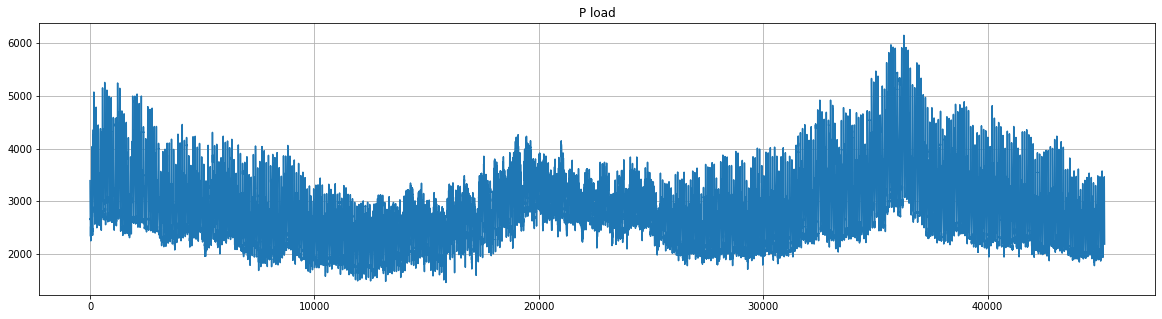

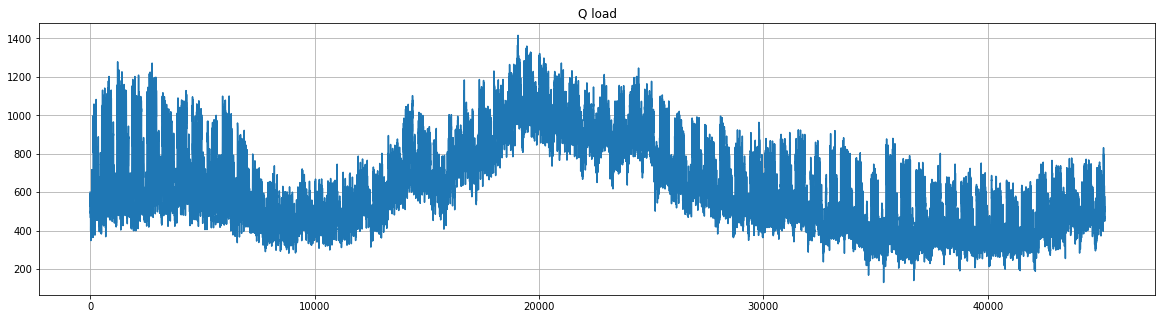

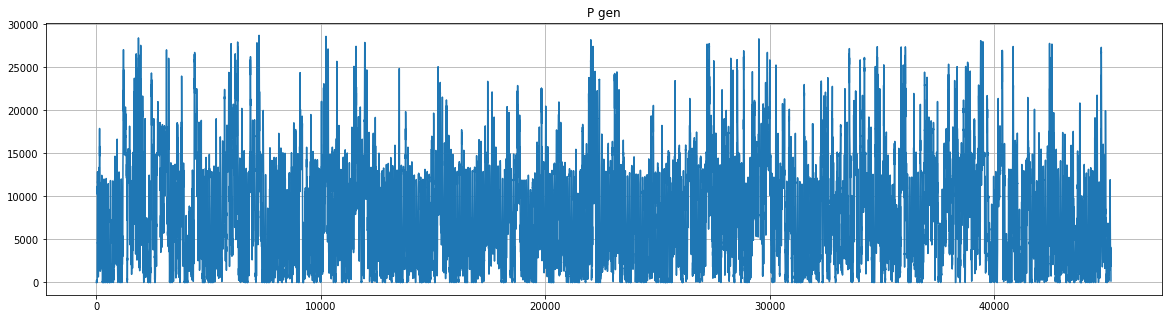

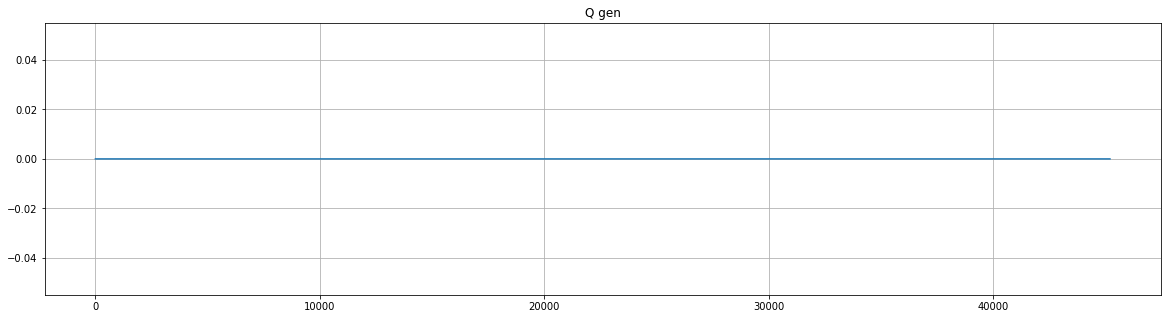

In [39]:
import matplotlib.pyplot as plt
_p_load_profile_kw.sum(axis=1).plot(figsize=(20, 5));plt.grid();plt.title('P load');plt.show()
_q_load_profile_kvar.sum(axis=1).plot(figsize=(20, 5));plt.grid();plt.title('Q load');plt.show()
_p_gen_profile_kw.sum(axis=1).plot(figsize=(20, 5));plt.grid();plt.title('P gen');plt.show()
_q_gen_profile_kvar.sum(axis=1).plot(figsize=(20, 5));plt.grid();plt.title('Q gen');plt.show()

In [40]:
run_timeseries(net, time_steps=time_steps, continue_on_divergence=False, verbose=True)#, runopf=pp.runopp(net, algorithm='nr'))

Progress: |██████████████████████████████████████████████████| 100.0% Complete



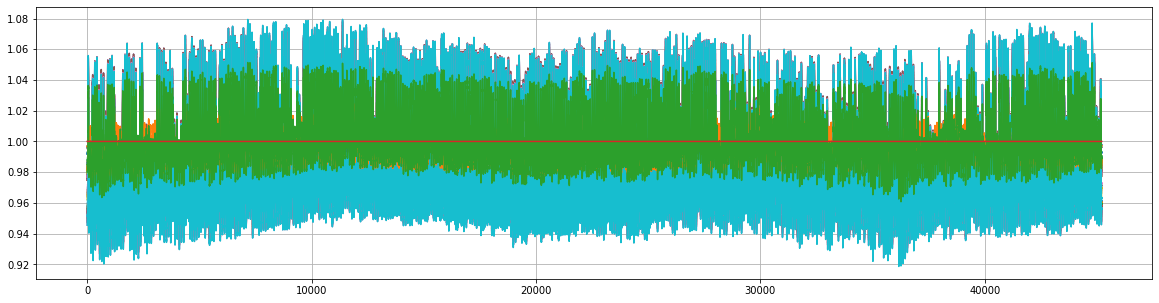

In [41]:
ow.output['res_bus.vm_pu'].plot(legend=False, figsize=(20,5));plt.grid();plt.show()

In order to use these results in the prediction models, the results are converted form net indexes to names and are stored in `.csv` files. 

In [42]:
# Function that matches index of a dataframe with the name of the element in the pandapower network.
def match_index_with_name(net, df, element_type='bus'):
    mapping = {column: net[element_type].iloc[column]['name'] for column in df.columns.values}
    return df.rename(columns=mapping)
pf_res_bus_vm_pu = match_index_with_name(net, ow.output['res_bus.vm_pu'], 'bus')
pf_res_bus_vm_pu['timestamps'] = timestamps_index
pf_res_line_loading_percent = match_index_with_name(net, ow.output['res_line.loading_percent'], 'line')
pf_res_line_loading_percent['timestamps'] = timestamps_index
pf_res_line_i_ka = match_index_with_name(net, ow.output['res_line.i_ka'], 'line')
pf_res_line_i_ka['timestamps'] = timestamps_index

Now we save the results to the `.csv` files to the folder '..\data\groundtruth'.

In [43]:
# Write pf_res_line_i_ka and pf_res_bus_vm_pu to csv in the folder '..\data\groundtruth'.
pf_res_line_i_ka.to_csv('..\\data\\ground_truth\\pf_res_line_i_ka.csv')
pf_res_bus_vm_pu.to_csv('..\\data\\ground_truth\\pf_res_bus_vm_pu.csv')